In [23]:
import pandas as pd
import numpy as np


## 3D Mechanism
The 3D-Laplace mechanism uses three variates:
1. Gamma distribution with formula $D_\epsilon, R(r) = \frac{1}{2}\epsilon^3r^2 exp^{-\epsilon r}$
2. $D{\epsilon},\Theta(\theta) = \frac{1}{\pi}$
3. $D{\epsilon},\Psi(\psi) = \frac{1}{2\pi}$

Both $\theta$ and $\psi$ are generated based on a unit sphere (sphere [1,1]).
Ergo, 2 and 3 are a vector $U = (\theta, \psi)$ and are scaled according to 1. So, when we have a random point $x_0 \in R^3$, the noise is added using $x_0 + Ur$
This is in line with the spherical coordinate system:

 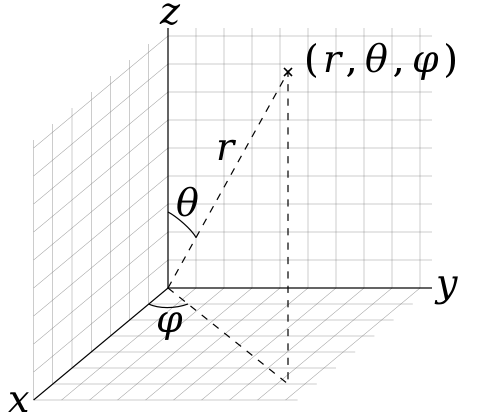
 


Steps to convert to nD-Laplace would then be:
- Instead of a unit sphere, we need to generate a unit hypersphere
- Modify the gaussian scaling

One of the difficulties for this is, we can't visualize it.


## nD-Laplace research
A hypersphere is conventionally defined as: $x1^2+x^2+x3^3+...+xd^2 < R^2$.
We are be-able to generate a unit hypersphere using this formula, where each point $x \in R^n$ is a unfiormly distributed random variable between $[-1,1]$. 
The PDF of the uniform distribution is $f(x) = \frac{1}{b-a}$, where $a$ and $b$ are the lower and upper bounds of the distribution.




In [24]:
np.random.uniform()

0.5476747375408642

In [25]:
def generate_unit_hypersphere(dimensions):
    x = np.random.uniform(0, 1, dimensions)
    sphere = 0
    for j in range(dimensions):
        sphere += x[j] ** 2
    return sphere

In [26]:
generate_unit_hypersphere(9)


3.0527406240639574

Now we whould sample random polar angle $\theta$ and azimuthal angle $\psi$ from the uniform hypersphere.

In [27]:
#muller-marsaglia method
import math
import random


def spherepicking(n):
    while True:           #to get rid off [0,0,0,0] case
        l = [random.gauss(0, 1) for i in range(n)]
        sumsq = sum([x * x for x in l])
        if sumsq > 0:
            break
    norm = 1.0 / math.sqrt(sumsq)
    pt = [x * norm for x in l]
    return pt

spherepicking(9)

[-0.07535198378724207,
 -0.08568226680396299,
 0.13936164916139857,
 -0.22185201536426258,
 -0.6323767948797631,
 -0.1456302170845474,
 0.4891070170029587,
 0.010380071067360198,
 -0.5078372287742415]

The paper propsed here implemented it similarly: https://arxiv.org/pdf/1811.10256.pdf. 

So instead of calculating z as $\theta$ and $\psi$, we need to calculate it as a random variable selected from a uniform n-sphere.
This can be done according to the formula formulated by georgemarsagliaChoosingPointSurface1972.
The amount of dimensions, are the scale of the gamma distribution (georgemarsagliaChoosingPointSurface1972, 3D-geoindstinguishability)


In [28]:
from scipy.stats import gamma
# generated based on https://mathworld.wolfram.com/Hypersphere.html
def ct(r, a):
    si = np.sin(a)
    si[0] = 1
    si = np.cumprod(si)
    co = np.cos(a)
    co = np.roll(co, -1)
    return si*co*r

def generate_nd_laplace_noise(x, epsilon):
    n = len(x)
    sphere_noise = spherepicking(n)
    r = gamma.rvs(n, scale=1/epsilon)
    print(r, ct(r, sphere_noise))
    u = ct(r, sphere_noise)
    z = x + u
    return z


!![title](nd_laplace.png)


In [29]:
x = np.random.uniform(0, 5, 10)
x

array([3.73253508, 2.613154  , 4.1197677 , 2.44082439, 2.64223756,
       1.68889651, 2.53859052, 4.33842711, 4.1431183 , 2.36182735])

In [30]:
generate_nd_laplace_noise(x, 0.5) 

13.363288360732803 [ 1.25414245e+01 -4.58544723e+00 -4.75935059e-01 -1.84799523e-01
  5.19598540e-02  2.12120069e-02  2.55183481e-03  2.33587856e-04
  9.35557501e-06  8.07136835e-07]


array([16.27395957, -1.97229324,  3.64383265,  2.25602487,  2.69419741,
        1.71010852,  2.54114235,  4.3386607 ,  4.14312765,  2.36182816])

As we can observe, the first 3 dimensions have considerable more noise than the rest of the dimensions added. To demonstrate this, we generate different gamma distributions for 5 dimensions (after this dimension, we notice decay) and 10 dimensions.

In [31]:
import matplotlib.pyplot as plt
epsilon = 0.5

def generate_gamma_samples(shape, samples):
    return gamma.rvs(shape, scale=1/epsilon, size=samples)
def plot_histogram(samples, bins):
    plt.hist(samples, bins=bins, density=True, alpha=0.6)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Gamma Distribution')
    plt.show()

In [32]:
def calculate_hypersphere_volume(radius, dimensions):
    numerator = math.pi**(dimensions/2) * radius**dimensions
    denominator = math.gamma(dimensions/2 + 1)
    volume = numerator / denominator
    return volume

def generate_example_data(dimensions = 20):
    data = { 'dimensions': [], 'volume': [] }
    for i in range(1, dimensions):
        volume = calculate_hypersphere_volume(1, i)
        data['dimensions'].append(i)
        data['volume'].append(volume)
    return pd.DataFrame(data)

In [33]:
df = generate_example_data()
df.head()

,dimensions,volume
0,1,2.000000
1,2,3.141593
2,3,4.188790
3,4,4.934802
4,5,5.263789


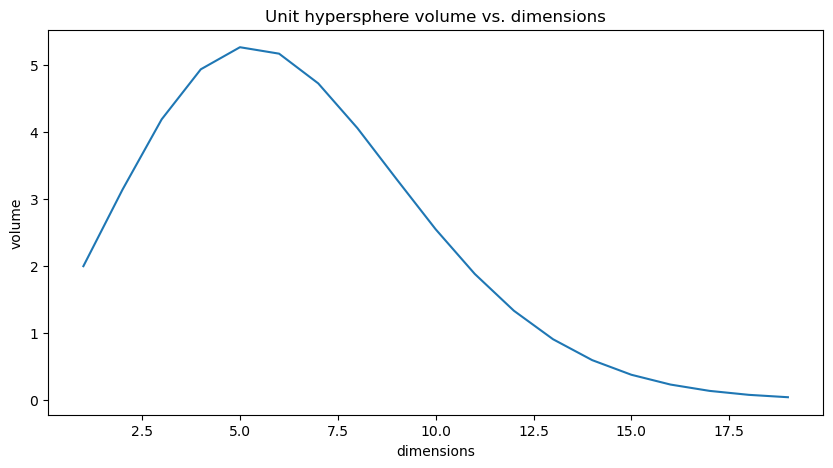

In [34]:
import seaborn as sns
fig = plt.figure(figsize=(10, 5))
sns.lineplot(x='dimensions', y='volume', data=df, ax=fig.gca())
fig.gca().set_title('Unit hypersphere volume vs. dimensions')
plt.show()


## Test dataset perturbation

In [67]:
def generate_nd_laplace_noise_for_dataset(dataframe: pd.DataFrame, epsilon: float):
    Z = []
    for index, row in dataframe.iterrows():
        perturbed_row = generate_nd_laplace_noise(row, epsilon)
        Z.append(perturbed_row)
    return pd.DataFrame(Z, columns=dataframe.columns)


In [68]:
seeds_dataset = pd.read_csv('../data/Seed_Data.csv', header=None, skiprows=1, names=['area', 'perimeter', 'compactness', 'length of kernel', 'width of kernel', 'asymmetry coefficient', 'length of kernel groove', 'class'])
seeds_dataset.head()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,0
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,0
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,0
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,0
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,0


In [69]:
seeds_dataset_y = seeds_dataset['class']
seeds_dataset = seeds_dataset.drop(columns=['class'])
seeds_dataset.head()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175


In [83]:
from Helpers import helpers
from sklearn.preprocessing import MinMaxScaler
epsilons = helpers.get_experiment_epsilons()
normalized_seeds_df = pd.DataFrame(MinMaxScaler().fit_transform(seeds_dataset), columns=seeds_dataset.columns)
normalized_seeds_df.head()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove
0,0.440982,0.502066,0.570780,0.486486,0.486101,0.189302,0.345150
1,0.405099,0.446281,0.662432,0.368806,0.501069,0.032883,0.215165
2,0.349386,0.347107,0.879310,0.220721,0.503920,0.251453,0.150665
3,0.306893,0.316116,0.793103,0.239302,0.533856,0.194243,0.140817
4,0.524079,0.533058,0.864791,0.427365,0.664291,0.076701,0.322994


In [85]:
for epsilon in epsilons:
    Z_pd = generate_nd_laplace_noise_for_dataset(normalized_seeds_df, epsilon)
    Z_pd.to_csv('./export/nd/perturbed_'+str(epsilon)+'.csv')

247.09300015908778 [ 2.46733936e+02  1.33070290e+01 -4.31928038e-01  2.26381974e-01
  1.74330319e-02  1.83448945e-02  3.23150269e-03]
131.59155046964463 [ 1.31563355e+02 -2.66072778e+00  5.59699641e-01 -1.54713596e-01
  5.64014490e-02 -4.65372885e-03  3.17857819e-03]
192.1098718647323 [ 1.91381153e+02 -1.62859828e+01 -3.74309937e+00 -4.43715237e-01
  9.61469945e-02  8.37294121e-02 -2.14970656e-03]
98.82075342236327 [ 9.17719442e+01 -3.66480596e+01 -6.04591747e-01  7.51066696e-02
 -9.99047722e-03  3.75187818e-03  1.58301042e-03]
80.94617706965268 [ 6.44238775e+01 -4.16062108e+01  2.48174848e+01  7.38187475e+00
  5.95267437e-01  1.23392016e-01  3.96020866e-02]
102.95569286597078 [ 9.26734489e+01  3.67689469e+01  2.42800460e+01  8.33626389e+00
 -6.39897730e-01 -3.49541360e-01 -7.41802442e-02]
90.90193982155162 [86.54731946 25.74256192 10.03037477 -2.74186614  1.23890456  0.55485497
 -0.27235046]
152.27196126678882 [ 1.40017827e+02  5.21324494e+01  2.51693490e+01 -1.47772392e+01
 -3.467968